In [1]:
import os
import sys
sys.path.append("..")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']= '1`'
os.environ['LIBRARY_PATH'] = '/usr/local/cuda/lib64'

In [3]:
from model import YModel
from gan import Generator, Discriminator, WSDiscriminator, GANLosses
from metrics import Metrics
from utils import sample_noise, iterate_minibatches, generate_data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)
#device = torch.device("cpu")


In [4]:
from comet_ml import API
import comet_ml

%matplotlib inline

my_cmap = plt.cm.jet
my_cmap.set_under('white')

In [5]:
from collections import defaultdict
comet_api = API()
comet_api.get()

['shir994']

In [6]:
def extract_metrics(exp, hyper_params, metrics, mask):
    for metric in exp.data['metrics']:
        metric_values = np.array(list(zip(*exp.metrics_raw[metric]))[1])
        metrics[metric].append([metric_values, hyper_params['data_size']])

In [7]:
#mask = list(np.arange(0, 20)) + [50] + [100]
mask = list(np.arange(1000))

In [8]:
# metrics = defaultdict(lambda : defaultdict(list))
# for experiment in comet_api.get("shir994/2d-convergence/"):
#     hyper_params = {}
#     for param in experiment.parameters:
#         hyper_params[param["name"]] = param["valueMin"]
#     if hyper_params['num_epochs'] == '1000' and\
#        hyper_params['TASK'] == '5' and\
#        ['1000_iter', '20size'] == experiment.tags:
#         extract_metrics(experiment, hyper_params, metrics[hyper_params['data_size'] + "_" + hyper_params['TASK']], mask)

# GAN convergence

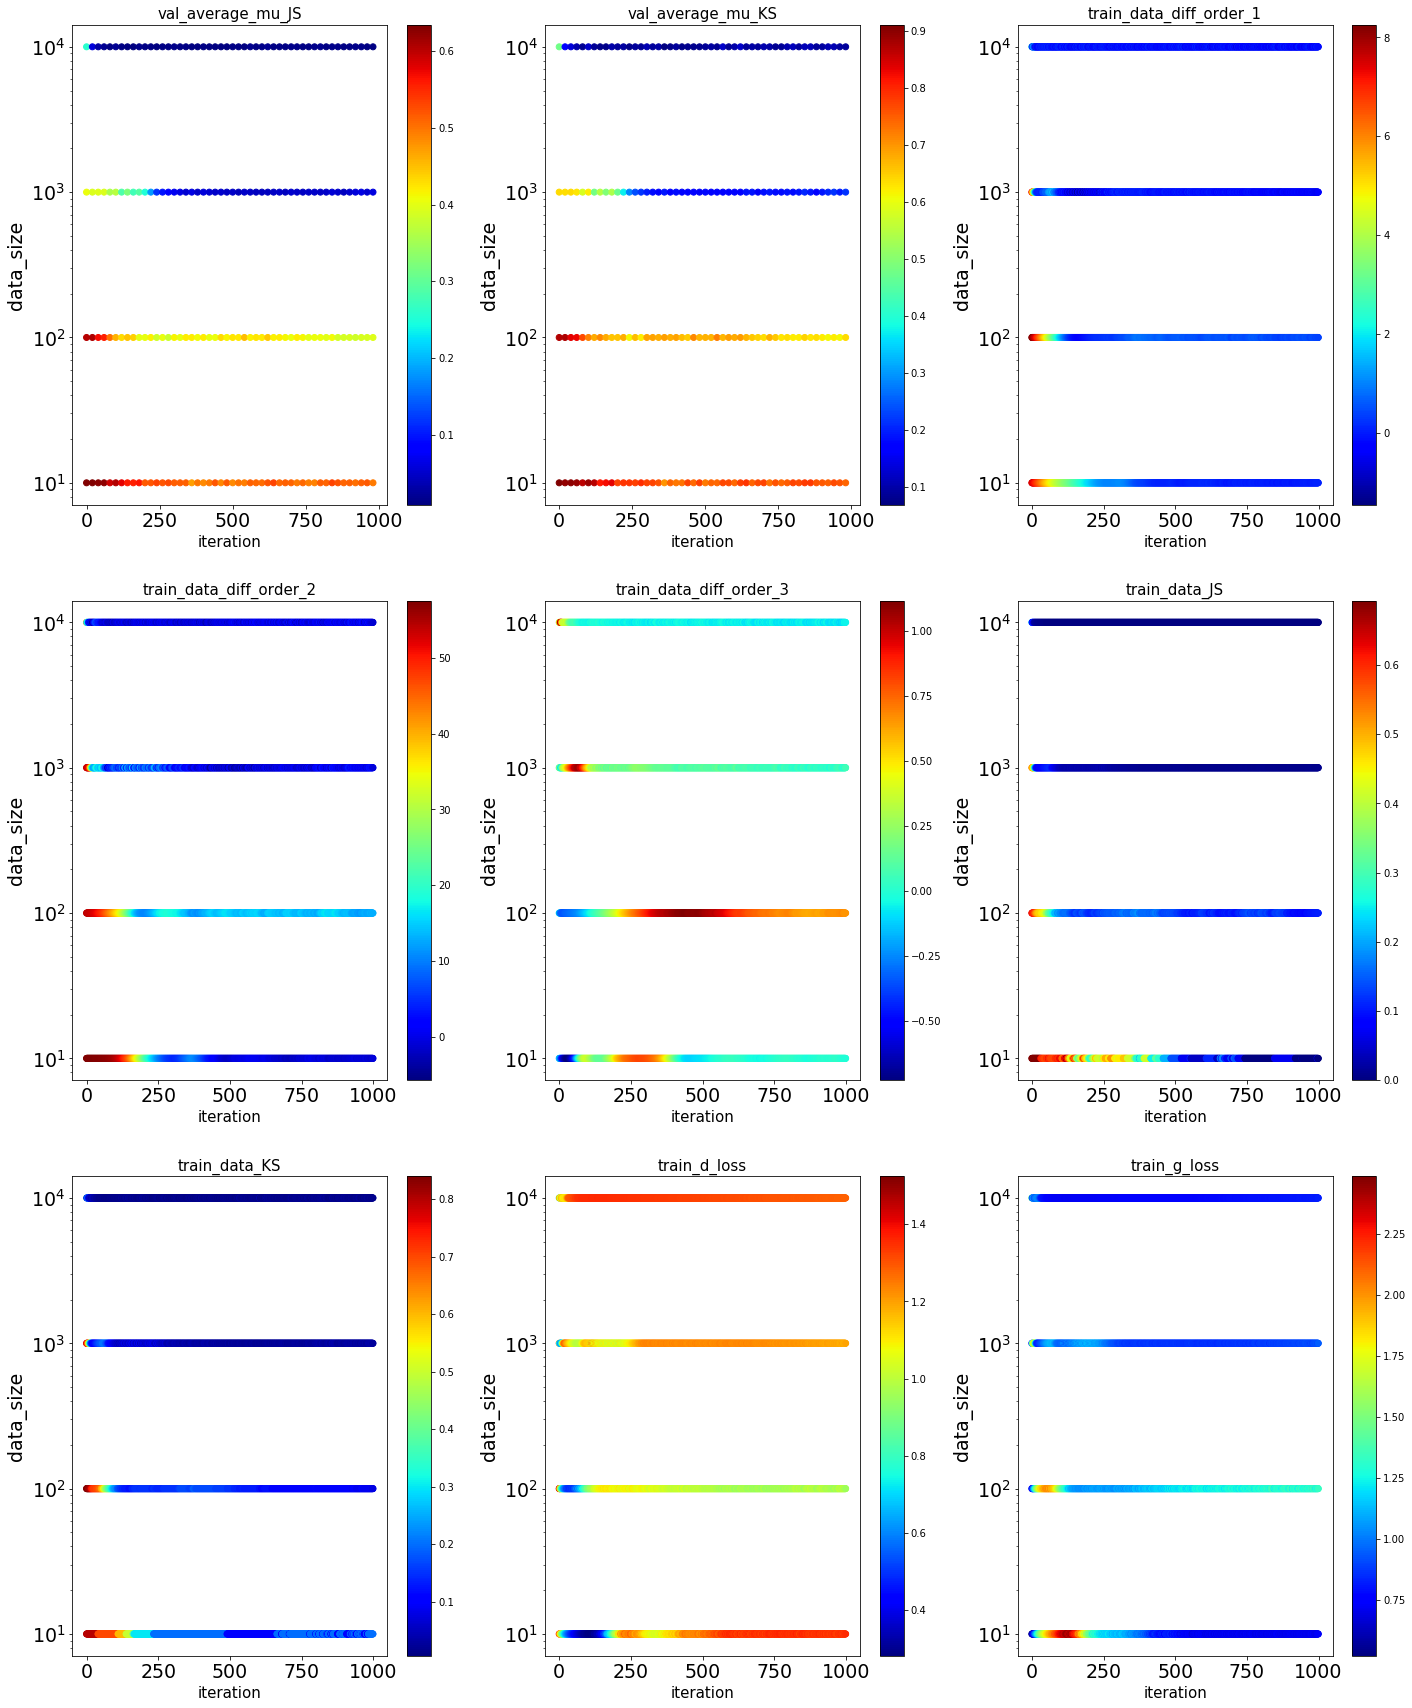

In [13]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')
plt.figure(figsize=(24,30))
index = 0
for metric in experiment.data['metrics']:
    if metric == "train_loss" or metric.startswith("train_data_gen"):
        continue
    plt.subplot(3,3, index + 1)
    index += 1
    
    data = []
    sizes = []
    iterations = []
    for key in metrics:
        data.append(metrics[key][metric][0][0])
        sizes.append([int(metrics[key][metric][0][1])] * metrics[key][metric][0][0].shape[0])
        iterations.append(np.arange(0, metrics[key][metric][0][0].shape[0]))
    
    if "average" in metric:
        metric = "val_" + "_".join(metric.split("_")[1:])
        iterations = np.array(iterations) * 20
        
    plt.scatter(iterations, np.array(sizes), c=data, cmap=my_cmap);#, norm=colors.LogNorm());
    plt.colorbar()
    plt.yscale("log")
    plt.title(metric, fontsize=15)
    plt.xlabel("iteration", fontsize=15)
    ax = plt.gca()
    ax.tick_params("both", labelsize=19)
    plt.ylabel("data_size", fontsize=19)


In [9]:
generators = {}
for exp in comet_api.get("shir994/2d-convergence/"):
    hyper_params = {}
    for param in exp.parameters:
        hyper_params[param["name"]] = param["valueMin"]
    if hyper_params['num_epochs'] != '1000' or\
       hyper_params['TASK'] != '5' or\
       ['1000_iter', '20size'] != exp.tags:
        continue
    
    TASK = int(hyper_params['TASK'])
    NOISE_DIM = int(hyper_params["NOISE_DIM"])    

    generator = Generator(NOISE_DIM, out_dim = 1, input_param=3).to(device)
    if TASK == 4:
        discriminator = WSDiscriminator(in_dim=1).to(device)
    else:
        discriminator = Discriminator(in_dim=1, input_param=3).to(device) 

    import io

    asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] ==
                "980.tar"][0]
    params = exp.get_asset(asset_id)
    state_dict = torch.load(io.BytesIO(params), map_location=device)
    generator.load_state_dict(state_dict['gen_state_dict'])
    generators[hyper_params['data_size'] + "_" + hyper_params['TASK']] = generator

In [10]:
from itertools import product
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
mu = torch.tensor(np.array(list(product(x,y)))).float()
y_sampler = YModel()

noise_size = 1000

In [11]:
%%time

y_surf = {}
for key in generators:
    y_mean = np.zeros([len(mu), 1])
    for i in range(len(mu)):
        noise = torch.Tensor(sample_noise(noise_size, NOISE_DIM)).to(device)
        mu_r = mu[i, :].reshape(1,-1).repeat(noise_size, 1).to(device)
        x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
        y_mean[i, 0] = generators[key](noise, torch.cat([mu_r,x_r],dim=1)).mean().item()
    y_surf[key] = y_mean

CPU times: user 2min 20s, sys: 2.14 s, total: 2min 22s
Wall time: 2min 22s


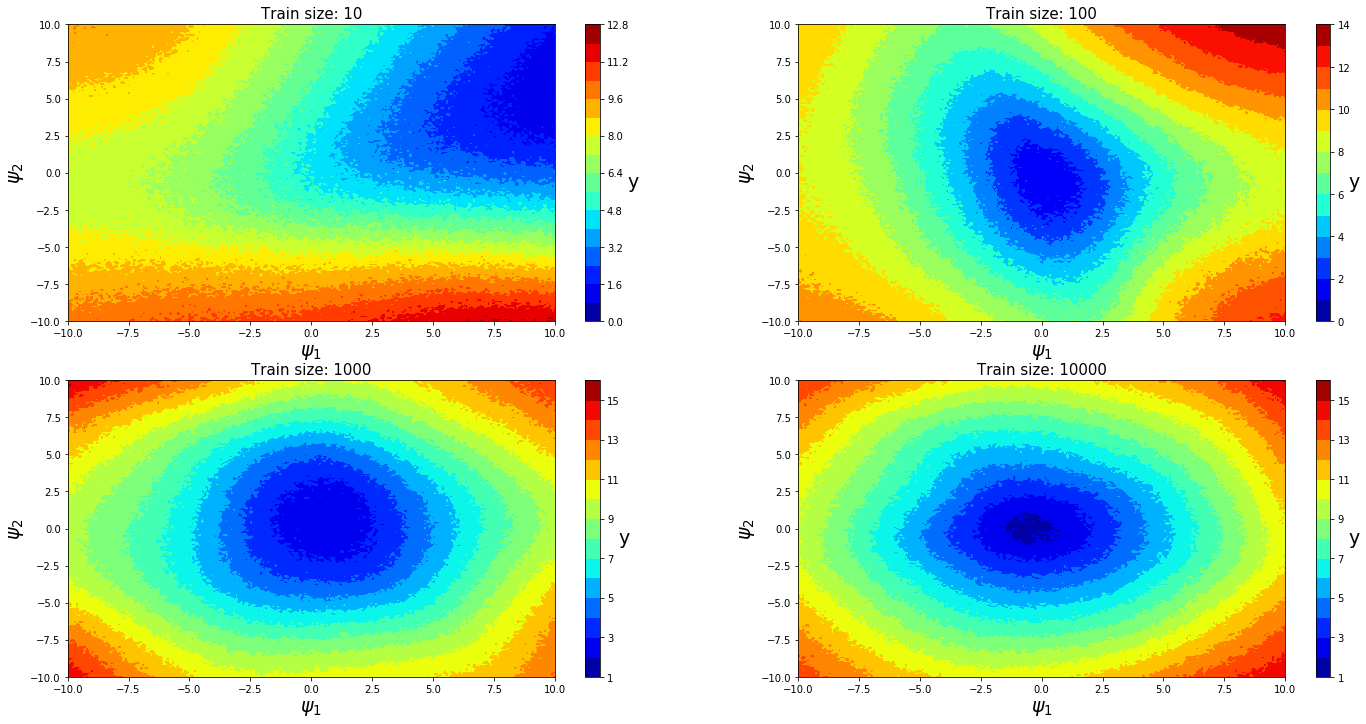

In [12]:
plt.figure(figsize=(24, 12))
for index, key in enumerate(y_surf):
    plt.subplot(2,2, index + 1)
    plt.contourf(*np.meshgrid(x,y), y_surf[key].reshape(-1, x.shape[0]).T, cmap=my_cmap, levels=15)
    plt.title(f"Train size: {key.split('_')[0]}", fontsize=15)
    cbar = plt.colorbar()
    plt.xlabel(f"$\psi_1$", fontsize=19)
    plt.ylabel(f"$\psi_2$", fontsize=19)
    cbar.set_label('y', rotation=0, fontsize=19)
plt.savefig("plots/y_surface_as_train.pdf", bbox_inches='tight')

# Optimisation procedure

In [13]:
from model import OptLoss

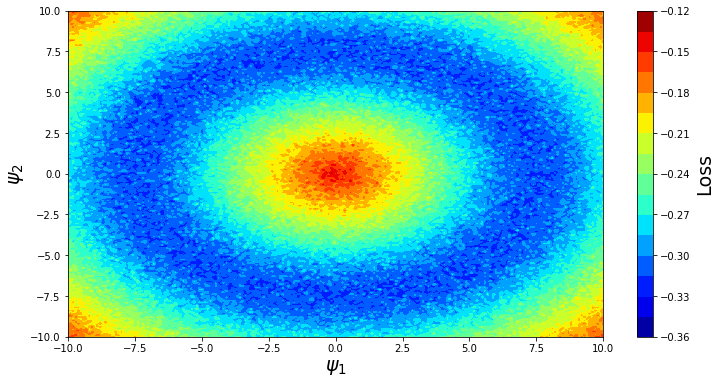

In [14]:
import numpy as np
plt.figure(figsize=(12,6))
#mu = dist.Uniform(-10,10).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

#plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
plt.contourf(*np.meshgrid(x,y), torch.transpose(rs.reshape(-1, x.shape[0]), 1,0), cmap=my_cmap, levels=15)

cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

In [15]:
%%time

loss_surf = {}
for key in generators:
    loss_val = np.zeros([len(mu), 1])
    for i in range(len(mu)):
        noise = torch.Tensor(sample_noise(noise_size, NOISE_DIM)).to(device)
        mu_r = mu[i, :].reshape(1,-1).repeat(noise_size, 1).to(device)
        x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
        samples = generators[key](noise, torch.cat([mu_r,x_r],dim=1))
        loss_val[i, 0] = OptLoss.SigmoidLoss(samples, 5, 10).mean().item()
    loss_surf[key] = loss_val

CPU times: user 2min 53s, sys: 2.37 s, total: 2min 55s
Wall time: 2min 55s


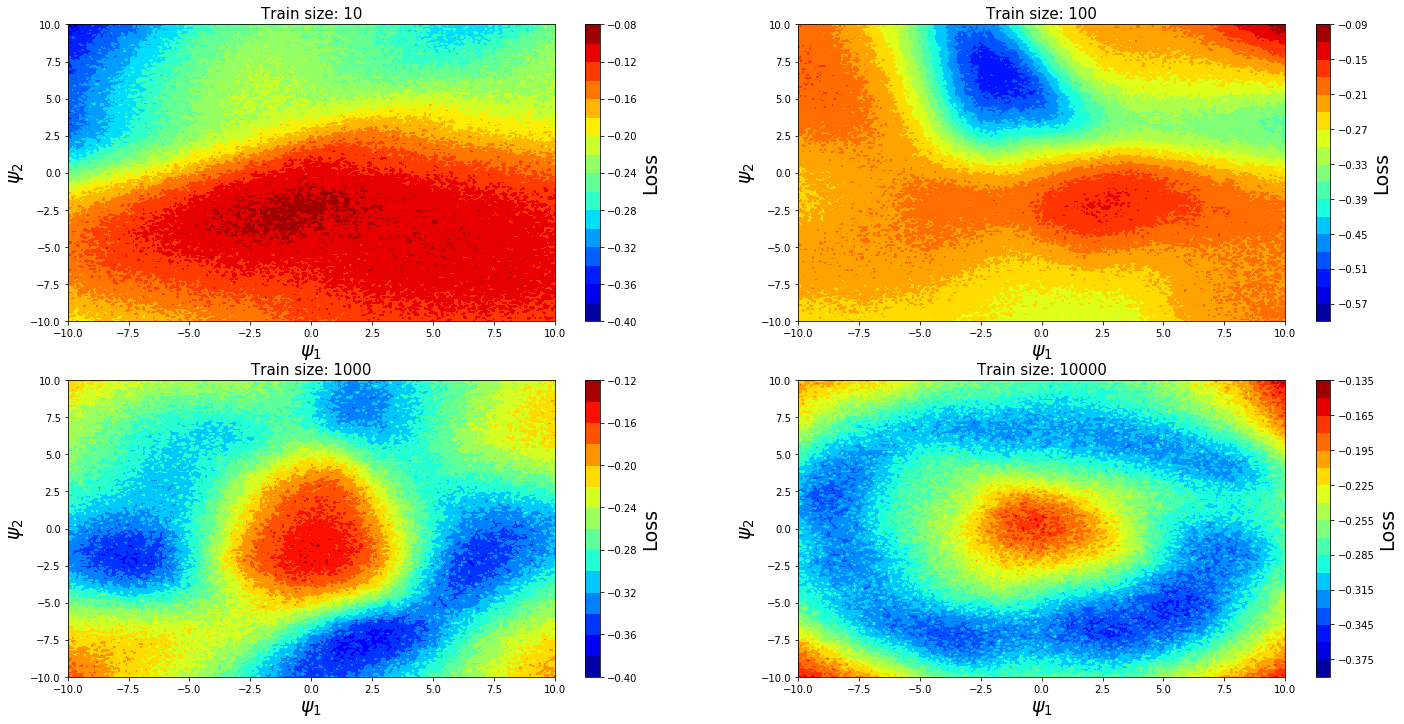

In [16]:
plt.figure(figsize=(24, 12))
for index, key in enumerate(loss_surf):
    plt.subplot(2,2, index + 1)
    plt.contourf(*np.meshgrid(x,y), loss_surf[key].reshape(-1, x.shape[0]).T, cmap=my_cmap, levels=15)
    plt.title(f"Train size: {key.split('_')[0]}", fontsize=15)
    cbar = plt.colorbar()
    plt.xlabel(f"$\psi_1$", fontsize=19)
    plt.ylabel(f"$\psi_2$", fontsize=19)
    cbar.set_label('Loss', rotation=90, fontsize=19)
plt.savefig("plots/loss_surface_as_train.pdf", bbox_inches='tight')              

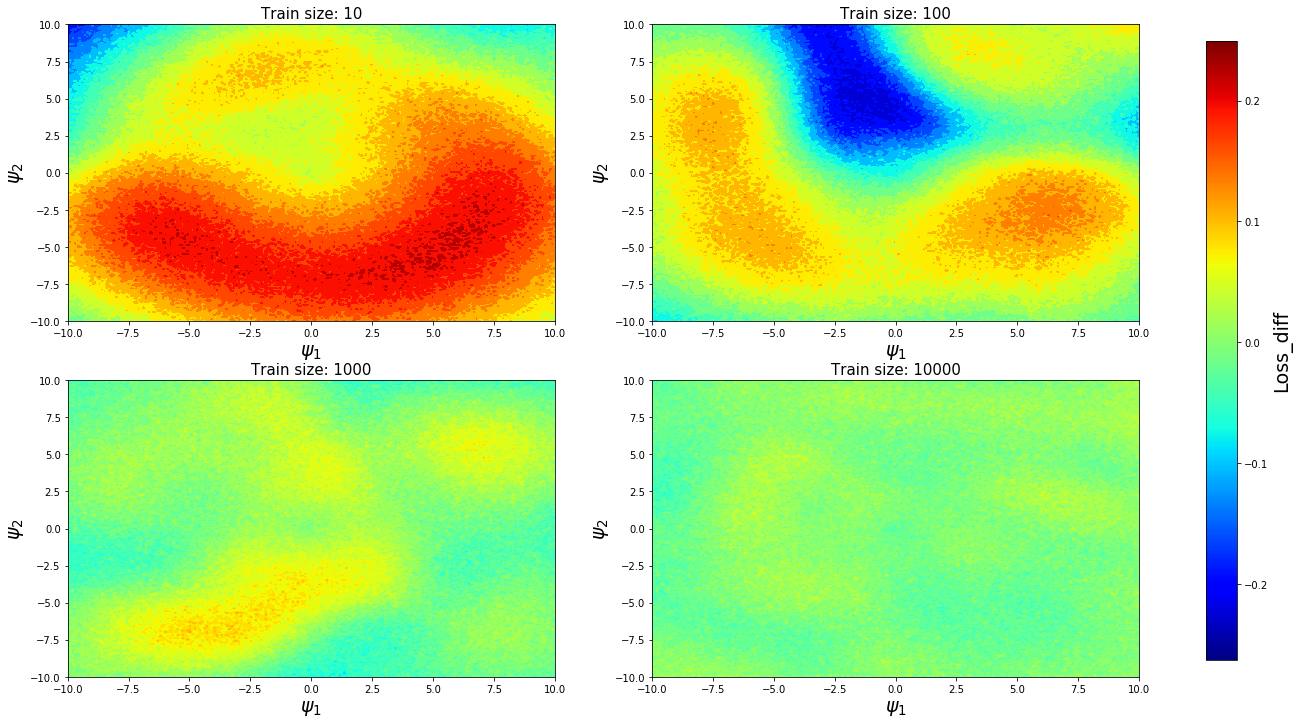

In [18]:
import matplotlib
vmin = 1e11
vmax = -1e12
for index, key in enumerate(loss_surf):
    dummy_data = (loss_surf[key].reshape(-1, x.shape[0]).T - np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)))
    vmin = min(vmin, dummy_data.min())
    vmax = max(vmax, dummy_data.max())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
for index, key in enumerate(loss_surf):
    ax = axes.flat[index]
    im = ax.contourf(*np.meshgrid(x,y),
                 loss_surf[key].reshape(-1, x.shape[0]).T - np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)),
                 cmap=my_cmap, levels=15,vmin=vmin, vmax=vmax)
    ax.set_title(f"Train size: {key.split('_')[0]}", fontsize=15)
    ax.set_xlabel(f"$\psi_1$", fontsize=19)
    ax.set_ylabel(f"$\psi_2$", fontsize=19)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)   
sc = matplotlib.cm.ScalarMappable(norm=norm, cmap=my_cmap)
sc._A = []
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), shrink=0.95)
cbar.set_label('Loss_diff', rotation=90, fontsize=19)                 
plt.savefig("plots/diff_surface_as_train.pdf", bbox_inches='tight')

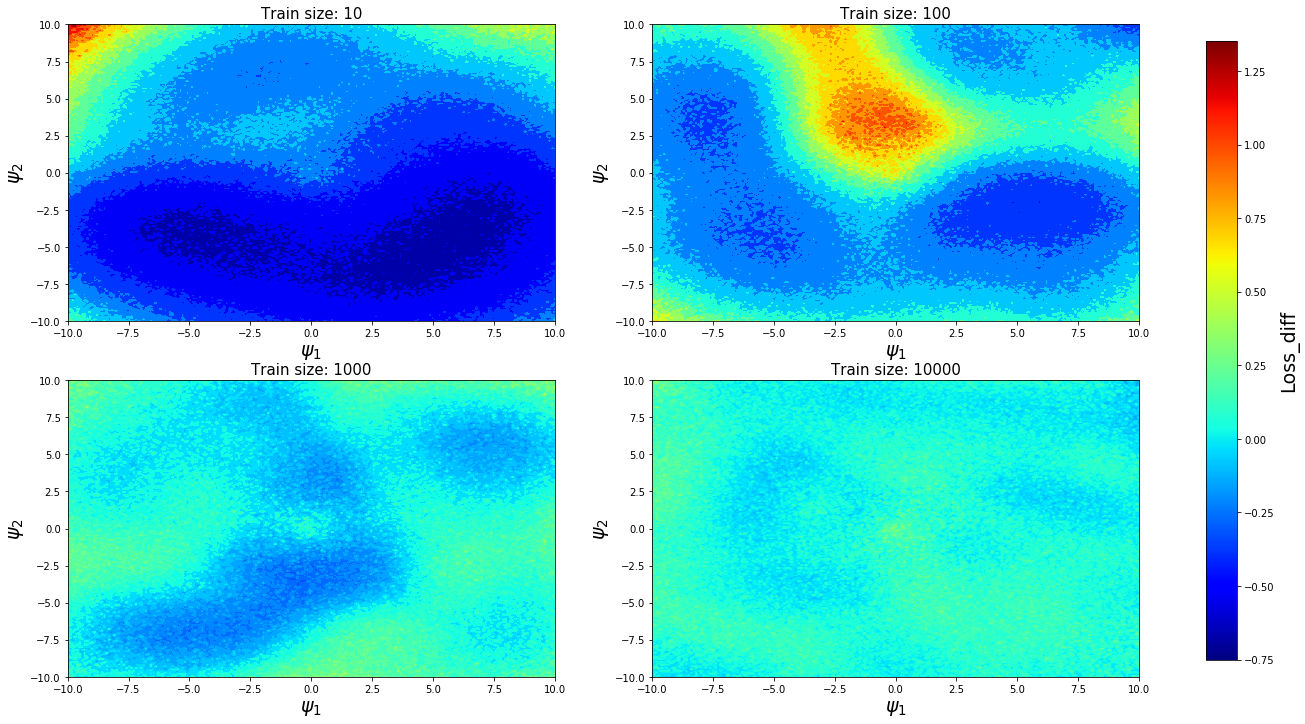

In [20]:
import matplotlib
vmin = 1e11
vmax = -1e12
for index, key in enumerate(loss_surf):
    dummy_data = (loss_surf[key].reshape(-1, x.shape[0]).T - np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)))/\
            np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0))
    vmin = min(vmin, dummy_data.min())
    vmax = max(vmax, dummy_data.max())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
for index, key in enumerate(loss_surf):
    ax = axes.flat[index]
    
    z_vals = (loss_surf[key].reshape(-1, x.shape[0]).T - np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)))/\
            np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0))
    im = ax.contourf(*np.meshgrid(x,y),
                 z_vals,
                 cmap=my_cmap, levels=15,vmin=vmin, vmax=vmax)
    ax.set_title(f"Train size: {key.split('_')[0]}", fontsize=15)
    ax.set_xlabel(f"$\psi_1$", fontsize=19)
    ax.set_ylabel(f"$\psi_2$", fontsize=19)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)   
sc = matplotlib.cm.ScalarMappable(norm=norm, cmap=my_cmap)
sc._A = []
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), shrink=0.95)
cbar.set_label('Loss_diff', rotation=90, fontsize=19)                 
#plt.savefig("plots/diff_surface_as_train.pdf", bbox_inches='tight')

In [99]:
# plt.figure(figsize=(24, 12))
# for index, key in enumerate(loss_surf):
#     plt.subplot(2,2, index + 1)
#     plt.contourf(*np.meshgrid(x,y),
#                  loss_surf[key].reshape(-1, x.shape[0]).T - np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)),
#                  cmap=my_cmap, levels=15)
#     plt.title(f"Train size: {key.split('_')[0]}", fontsize=15)
#     cbar = plt.colorbar()
#     plt.xlabel(f"$\psi_1$", fontsize=19)
#     plt.ylabel(f"$\psi_2$", fontsize=19)
#     cbar.set_label('Loss', rotation=90, fontsize=19)
# #plt.savefig("plots/diff_surface_as_train.svg")

# Train data parameter space

In [55]:
train_datasets = []
for exp in comet_api.get("shir994/2d-convergence/"):
    hyper_params = {}
    for param in exp.parameters:
        hyper_params[param["name"]] = param["valueMin"]
    if hyper_params['num_epochs'] != '1000' or\
       hyper_params['TASK'] != '5' or\
       ['1000_iter', '20size'] != exp.tags:
        continue
    

    asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] ==
                "train_inputs.npy"][0]
    train_datasets.append(np.load(io.BytesIO(exp.get_asset(asset_id))))

In [134]:
def find_colors(set_index):
    valcounts = np.unique(train_datasets[set_index][:,:2],axis=0, return_counts=True)
    count_map = {}
    for index in range(len(valcounts[0])):
        count_map[tuple(valcounts[0][index])] = valcounts[1][index]
    return np.apply_along_axis(lambda x: count_map[tuple(x)], 1, train_datasets[set_index][:,:2])    

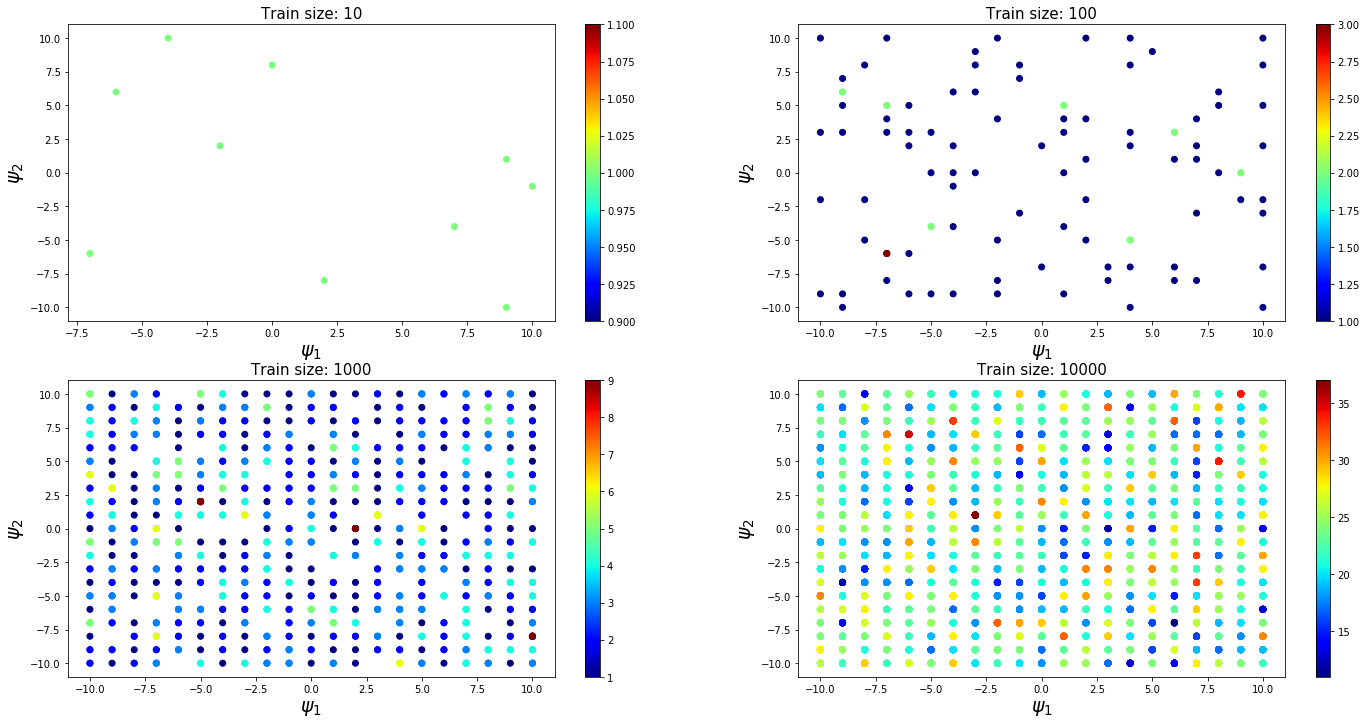

In [137]:
plt.figure(figsize=(24, 12))
for index in range(len(train_datasets)):
    plt.subplot(2,2, index + 1)
    plt.scatter(train_datasets[index][:, 0], train_datasets[index][:, 1], c=find_colors(index), cmap=my_cmap)
    plt.title(f"Train size: {len(train_datasets[index])}", fontsize=15)
    plt.xlabel(f"$\psi_1$", fontsize=19)
    plt.ylabel(f"$\psi_2$", fontsize=19)
    plt.colorbar()
plt.savefig("plots/train_params.pdf", bbox_inches='tight')

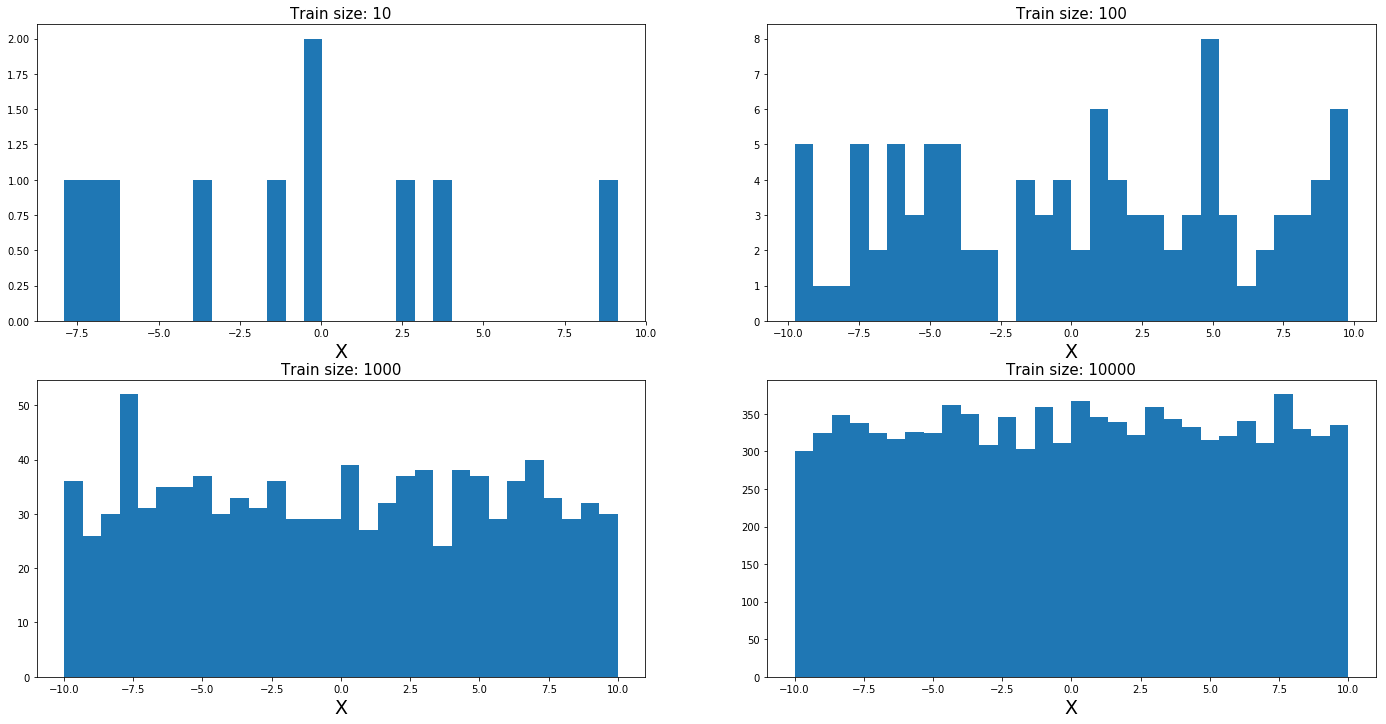

In [61]:
plt.figure(figsize=(24, 12))
for index in range(len(train_datasets)):
    plt.subplot(2,2, index + 1)
    plt.hist(train_datasets[index][:, 2], bins=30)
    plt.title(f"Train size: {len(train_datasets[index])}", fontsize=15)
    plt.xlabel(f"X", fontsize=19)